OUTTA AI 부트캠프 딥러닝반 - Diffusion Model

# **Diffusion Model 살펴보기**

### **1. PyTorch 라이브러리 임포트**

PyTorch 라이브러리를 임포트하고 사용 가능한 최적의 디바이스를 선택합니다.

(1) 먼저 Apple Silicon GPU (MPS)를 확인합니다.

(2) 다음으로 NVIDIA GPU (CUDA)를 확인합니다.

(3) 둘 다 사용할 수 없는 경우 CPU를 사용합니다.

In [ ]:
import torch
import torch.nn as nn


if torch.backends.mps.is_available():
    my_device = torch.device('mps')
elif torch.cuda.is_available():
    my_device = torch.device('cuda')
else:
    my_device = torch.device('cpu')


### **2. U-Net 아키텍처**

시간 정보를 고려한 U-Net 아키텍처를 아래와 같이 구현합니다.


In [ ]:

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels, track_running_stats = False),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels, track_running_stats = False),
            nn.ReLU(),
        )


    def forward(self, x):
        return self.double_conv(x)


class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

        self.time_mlp = nn.Sequential(
                nn.Linear(time_dim, out_channels),
                nn.ReLU()
        )

    def forward(self, x, t):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)

        t = self.time_mlp(t)
        t = t.unsqueeze(-1).unsqueeze(-1)

        return (down_out+t, skip_out)


class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim):
        super(UpBlock, self).__init__()
        self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)
        self.double_conv = DoubleConv(in_channels, out_channels)

        self.time_mlp = nn.Sequential(
                nn.Linear(time_dim, out_channels),
                nn.ReLU()
        )

    def forward(self, down_input, skip_input, t):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        x = self.double_conv(x)

        t = self.time_mlp(t)
        t = t.unsqueeze(-1).unsqueeze(-1)
        return x+t


class UNetTime(nn.Module):
    def __init__(self):
        super(UNetTime, self).__init__()
        self.time_dim = 32

        self.time_mlp = nn.Sequential(
                nn.Linear(self.time_dim, self.time_dim),
                nn.ReLU()
            )

        self.down_conv1 = DownBlock(1, 64, self.time_dim)
        self.down_conv2 = DownBlock(64, 128, self.time_dim)
        self.down_conv3 = DownBlock(128, 256, self.time_dim)
        self.down_conv4 = DownBlock(256, 512, self.time_dim)
        self.double_conv = DoubleConv(512, 1024)
        self.up_conv4 = UpBlock(512 + 1024, 512, self.time_dim)
        self.up_conv3 = UpBlock(256 + 512, 256, self.time_dim)
        self.up_conv2 = UpBlock(128 + 256, 128, self.time_dim)
        self.up_conv1 = UpBlock(128 + 64, 64, self.time_dim)

        self.conv_last = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x, t):
        time_embedding = self.pos_encoding(t)
        time_embedding = self.time_mlp(time_embedding)

        x, skip1_out = self.down_conv1(x, time_embedding)
        x, skip2_out = self.down_conv2(x, time_embedding)
        x, skip3_out = self.down_conv3(x, time_embedding)
        x, skip4_out = self.down_conv4(x, time_embedding)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out, time_embedding)
        x = self.up_conv3(x, skip3_out, time_embedding)
        x = self.up_conv2(x, skip2_out, time_embedding)
        x = self.up_conv1(x, skip1_out, time_embedding)
        x = self.conv_last(x)

        return x

    def pos_encoding(self, t):
        channels = 32
        inv_freq = 1.0 / (
            10000 ** (torch.arange(0, channels, 2, device=my_device).float() / channels)
        )

        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc


model = UNetTime()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model.to(my_device)

Num params:  37026465


UNetTime(
  (time_mlp): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
  )
  (down_conv1): DownBlock(
    (double_conv): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (5): ReLU()
      )
    )
    (down_sample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (time_mlp): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): ReLU()
    )
  )
  (down_conv2): DownBlock(
    (double_conv): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1)

위 셀을 자세히 살펴봅시다. 주요 구성 요소는 다음과 같습니다:

* DoubleConv: 두 개의 연속된 컨볼루션 레이어, 배치 정규화, ReLU 활성화 함수로 구성됩니다.
* DownBlock: 다운샘플링을 수행하는 블록으로, DoubleConv와 * MaxPooling을 포함합니다.
* UpBlock: 업샘플링을 수행하는 블록으로, 전치 컨볼루션과 DoubleConv를 포함합니다.
* UNetTime: 전체 U-Net 아키텍처를 구현한 클래스입니다. 인코더(다운샘플링), 디코더(업샘플링), 스킵 연결을 포함합니다.

> 특징:
시간 정보를 임베딩하여 각 블록에 추가합니다.
포지셔널 인코딩을 사용하여 시간 정보를 효과적으로 표현합니다.
스킵 연결을 통해 고해상도 특징을 보존합니다.
마지막으로, 모델 인스턴스를 생성하고 총 파라미터 수를 출력한 후, 선택된 디바이스로 모델을 이동시킵니다.

### **3. MNIST 데이터 로드**

MNIST 데이터셋을 로드하고 전처리하는 과정입니다

In [ ]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.Resize((32,32))
     transforms.ToTensor(),
     transforms.Lambda(lambda x: (x * 2) - 1) # Scale between [-1, 1]
    ])

BATCH_SIZE = 64
SAMPLE_STEP = 300
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

위와 같이 MNIST 데이터셋을 로드했습니다.

1. 이후 데이터 변환 파이프라인을 정의합니다.

  * 이미지 크기를 32x32로 조정
  * 텐서로 변환
  * 픽셀 값을 [-1, 1] 범위로 정규화


2. 훈련 및 테스트 데이터셋을 로드합니다.

3. 데이터 로더를 생성하여 배치 단위로 데이터를 효율적으로 로드할 수 있게 합니다.
  * 훈련 데이터는 배치 크기 64로 설정하고, 셔플링을 적용합니다.
  * 테스트 데이터는 배치 크기 1로 설정합니다.



이렇게 준비된 데이터는 모델 훈련 및 평가에 사용됩니다.

### **4. Noising과 Denoising 과정**

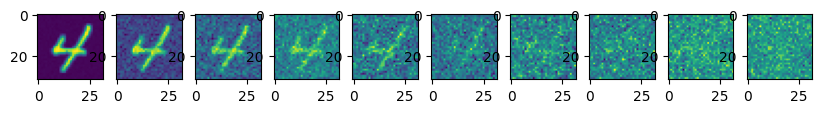

In [ ]:
import matplotlib.pyplot as plt


class RandomNoise():
    def __init__(self, sample_step, device) -> None:
        self.device = device
        self.betas = torch.linspace(start=0.0001,end=0.02, steps=sample_step)
        self.alphas = 1. - self.betas
        self.alpha_hat = torch.cumprod(input=self.alphas, dim=0).to(self.device)
        self.sqrt_alpha_hat = torch.sqrt(self.alpha_hat)
        self.sqrt_one_minus_alpha_hat = torch.sqrt(1. - self.alpha_hat)
        self.alphas = self.alphas.to(self.device)
        self.betas = self.betas.to(self.device)


    @torch.no_grad()
    def apply_random_noise(self, img_tensor, step):
        noise = torch.randn_like(img_tensor, device=self.device)

        sqrt_alpha_hat = self.sqrt_alpha_hat[step][:,None,None,None]
        sqrt_one_minus_alpha_hat = self.sqrt_one_minus_alpha_hat[step][:,None,None,None]
        noisy_img = sqrt_alpha_hat * img_tensor + sqrt_one_minus_alpha_hat * noise

        return noisy_img, noise

    @torch.no_grad()
    def restore_img(self, img_tensor, pred_noise, step): #step is scalar
        beta = self.betas[step]
        sqrt_one_minus_alpha_hat = self.sqrt_one_minus_alpha_hat[step]

        rest_img = torch.sqrt(1./self.alphas[step]) * (img_tensor - beta/sqrt_one_minus_alpha_hat*pred_noise)


        if 1 < step:
            noise = torch.randn_like(img_tensor, device=self.device)
        else:
            noise = torch.zeros_like(img_tensor, device=self.device)

        rest_img = rest_img + torch.sqrt(beta) * noise
        rest_img = rest_img.to(my_device)
        return rest_img

    @torch.no_grad()
    def restore_img2(self, img_tensor, pred_noise, step): #step is scalar
        beta = self.betas[step]
        sqrt_one_minus_alpha_hat = self.sqrt_one_minus_alpha_hat[step]

        rest_img = torch.sqrt(1./self.alphas[step]) * (img_tensor - beta/sqrt_one_minus_alpha_hat*pred_noise)

        if 0 < step:
            noise = torch.randn_like(img_tensor, device=self.device)
        else:
            noise = torch.zeros_like(img_tensor, device=self.device)

        rest_img = rest_img + torch.sqrt(beta*(1. - self.alpha_hat[step-1])/(1.-self.alpha_hat[step])) * noise
        return rest_img



fig, axes = plt.subplots(1, 10, figsize=(10, 1))
random_noise = RandomNoise(sample_step=SAMPLE_STEP, device='cpu')

num_images = 10
stepsize = int(SAMPLE_STEP/num_images)
images = next(iter(training_loader))[0]
sample_times = torch.linspace(start=0, end=SAMPLE_STEP-1, steps=num_images).int()


for idx in range(0,num_images):
    noisy_imgs, _ = random_noise.apply_random_noise(images,sample_times[idx][None])
    img_np = noisy_imgs[0].detach().squeeze()
    axes[idx].imshow((img_np+1)/2)
plt.show()


위 셀은 디퓨전 모델의 핵심 부분인 RandomNoise 클래스를 정의하고, 노이즈 추가 과정을 시각화합니다.

1. RandomNoise 클래스:
  * init 메소드:
    * 베타 스케줄을 정의합니다 (0.0001에서 0.02까지).
    * 알파, 알파_hat 등 디퓨전 과정에 필요한 값들을 계산합니다.
    * 모든 텐서를 지정된 디바이스로 이동시킵니다.
  * apply_random_noise 메소드:
    * 이미지에 가우시안 노이즈를 추가합니다.
    * 노이즈 추가 공식: sqrt(α_t) * x_0 + sqrt(1-α_t) * ε
    * 노이즈가 추가된 이미지와 원본 노이즈를 반환합니다.
  * restore_img 메소드:
    * 노이즈 예측을 사용하여 이미지를 복원하는 첫 번째 방법입니다.
    * DDPM(Denoising Diffusion Probabilistic Models) 논문의 알고리즘을 구현합니다.
  * restore_img2 메소드:
    * 노이즈 예측을 사용하여 이미지를 복원하는 두 번째 방법입니다.
    * DDIM(Denoising Diffusion Implicit Models) 논문의 알고리즘을 구현합니다.
2. 노이즈 적용 과정 시각화:
  * 10개의 이미지를 표시할 수 있는 서브플롯을 생성합니다.
  * RandomNoise 객체를 생성합니다.
  * 훈련 데이터로더에서 첫 번째 배치의 이미지를 가져옵니다.
  * 10개의 다른 시간 스텝에 대해 노이즈를 적용합니다.
  * 각 시간 스텝에서의 노이즈가 적용된 이미지를 시각화합니다.


이 코드는 디퓨전 모델의 노이즈 추가 및 제거 과정을 구현하고, 노이즈 추가 과정을 시각적으로 보여줍니다. 이를 통해 시간이 지남에 따라 이미지에 노이즈가 어떻게 추가되는지 확인할 수 있습니다. 이는 디퓨전 모델의 작동 원리를 이해하는 데 매우 중요합니다.

### **5. 디퓨전 모델의 훈련 과정과 이미지 생성 과정**

아래 셀은 디퓨전 모델의 훈련 과정과 이미지 생성 과정을 구현합니다
1. 모델 훈련 설정:
  * RandomNoise 객체 생성
  *	MSE 손실 함수와 Adam 옵티마이저 설정
  *	에포크 수 설정 (EPOCHS = 500)

2. 훈련 루프:
  *	각 에포크마다 데이터로더에서 배치를 가져옵니다.
  *	랜덤한 시간 스텝에서 이미지에 노이즈를 추가합니다.
  *	모델이 노이즈를 예측하도록 훈련합니다.
  *	손실을 계산하고 역전파를 수행하여 모델을 업데이트합니다.
  *	100 배치마다 현재 손실을 출력합니다.

3. 이미지 생성 및 시각화:
  *	각 에포크가 끝날 때마다 모델을 평가 모드로 전환합니다.
  *	순수한 노이즈 이미지에서 시작하여 점진적으로 노이즈를 제거합니다.
  *	노이즈 제거 과정의 10개 단계를 시각화합니다.

주요 특징:
  *	모델은 노이즈를 예측하도록 훈련됩니다. 이는 디퓨전 모델의 핵심 아이디어입니다.
  *	이미지 생성 과정에서는 노이즈에서 시작하여 점진적으로 노이즈를 제거합니다.
  *	생성된 이미지는 각 에포크마다 시각화되어 모델의 학습 진행 상황을 확인할 수 있습니다.


이 코드는 디퓨전 모델의 전체 훈련 및 생성 과정을 구현하고 있으며, 모델이 학습함에 따라 점점 더 나은 품질의 이미지를 생성할 수 있게 됩니다.



EPOCH 0
 batch0, running_loss1.109039545059204
 batch100, running_loss0.12101440054207745
 batch200, running_loss0.09403975467331967
 batch300, running_loss0.08424691055155671
 batch400, running_loss0.0779183242758016
 batch500, running_loss0.07283625056494972
 batch600, running_loss0.06900444659660145
 batch700, running_loss0.06595594810584983
 batch800, running_loss0.06375966814536131
 batch900, running_loss0.06180082211533477


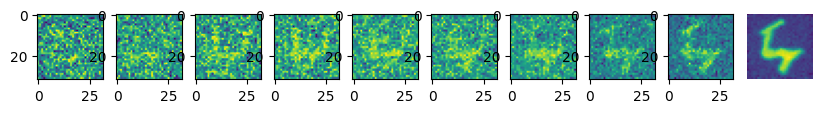

EPOCH 1
 batch0, running_loss0.04547338932752609
 batch100, running_loss0.04268081506511363
 batch200, running_loss0.041922958169262205
 batch300, running_loss0.04160227203289932
 batch400, running_loss0.04134647071621662
 batch500, running_loss0.04128719704177327
 batch600, running_loss0.04106469812513191
 batch700, running_loss0.04084367136312875
 batch800, running_loss0.040536556597543266
 batch900, running_loss0.040383234374084566


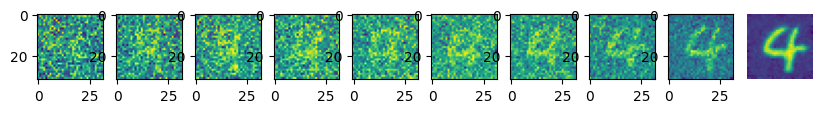

EPOCH 2
 batch0, running_loss0.04376193881034851
 batch100, running_loss0.038864620564745204
 batch200, running_loss0.038459031402471644
 batch300, running_loss0.03779455703185048
 batch400, running_loss0.03758205819940032
 batch500, running_loss0.03750093651939176
 batch600, running_loss0.03730727509655889
 batch700, running_loss0.037252393143302025
 batch800, running_loss0.037056522327620585
 batch900, running_loss0.036891102406313096


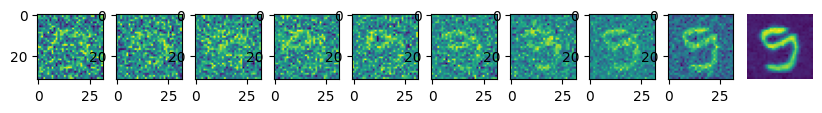

EPOCH 3
 batch0, running_loss0.03556366637349129
 batch100, running_loss0.03680377228572817
 batch200, running_loss0.03651871772214251
 batch300, running_loss0.03657254178163617
 batch400, running_loss0.036031355672606506
 batch500, running_loss0.03598228937568898
 batch600, running_loss0.03568386937028259
 batch700, running_loss0.035445091653397355
 batch800, running_loss0.03537689452379309
 batch900, running_loss0.03523264882608537


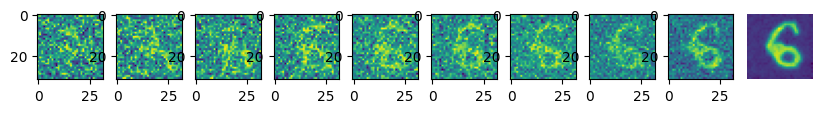

EPOCH 4
 batch0, running_loss0.03886961191892624
 batch100, running_loss0.03385257317066783
 batch200, running_loss0.03389676875291179
 batch300, running_loss0.03374576156470071
 batch400, running_loss0.033763109067654666
 batch500, running_loss0.033829283686782306
 batch600, running_loss0.033813829947504745
 batch700, running_loss0.03387030837167262
 batch800, running_loss0.03388796974154894
 batch900, running_loss0.033818170331112556


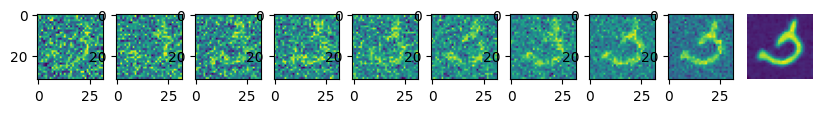

EPOCH 5
 batch0, running_loss0.03094393201172352
 batch100, running_loss0.0328671934617923
 batch200, running_loss0.03314700193554904
 batch300, running_loss0.033369971624888056
 batch400, running_loss0.033122687143020496
 batch500, running_loss0.033106424122632386
 batch600, running_loss0.032941581569797984
 batch700, running_loss0.032863707296263305
 batch800, running_loss0.03278704248275724
 batch900, running_loss0.03272985817903816


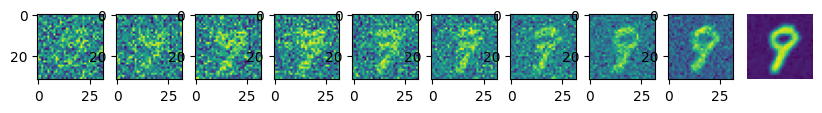

EPOCH 6
 batch0, running_loss0.030139179900288582
 batch100, running_loss0.03370287238002414
 batch200, running_loss0.03352061002075079
 batch300, running_loss0.033478656882711025
 batch400, running_loss0.03314425599322355
 batch500, running_loss0.03297027547336267
 batch600, running_loss0.03288006436966124
 batch700, running_loss0.03290088547555764
 batch800, running_loss0.03281188127439418
 batch900, running_loss0.032648062486445466


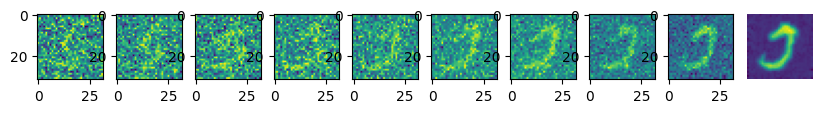

EPOCH 7
 batch0, running_loss0.038019124418497086
 batch100, running_loss0.03184293691843453
 batch200, running_loss0.03221109232388029
 batch300, running_loss0.03200419771290103
 batch400, running_loss0.03189667387217506
 batch500, running_loss0.0318418579387986
 batch600, running_loss0.031933229450700484
 batch700, running_loss0.03197642984121145
 batch800, running_loss0.03186018154555269
 batch900, running_loss0.03188541410418515


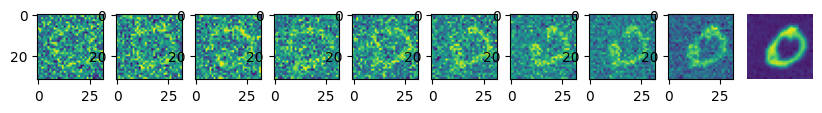

EPOCH 8
 batch0, running_loss0.02811182662844658
 batch100, running_loss0.031797074058120794
 batch200, running_loss0.031525859961388125
 batch300, running_loss0.03149452751681852
 batch400, running_loss0.031291640231251125
 batch500, running_loss0.031167173271110196
 batch600, running_loss0.031210082166281197
 batch700, running_loss0.03123094073195175
 batch800, running_loss0.03125604016057561
 batch900, running_loss0.03126413405942136


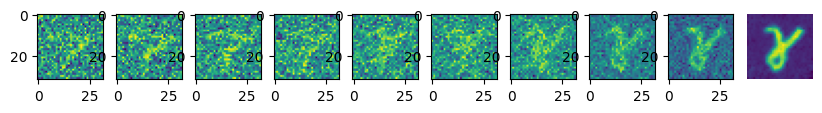

EPOCH 9
 batch0, running_loss0.035287097096443176
 batch100, running_loss0.03035940202229684
 batch200, running_loss0.03077807099516712
 batch300, running_loss0.030999616462972474
 batch400, running_loss0.03106897232817147
 batch500, running_loss0.030961215752595198
 batch600, running_loss0.03101068215689524
 batch700, running_loss0.031039919757341352
 batch800, running_loss0.031075887037871334
 batch900, running_loss0.03100437045378505


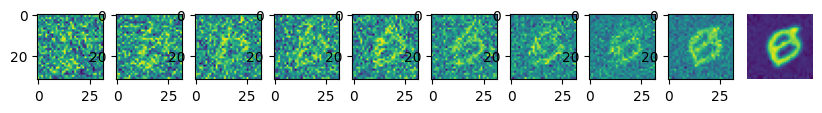

EPOCH 10
 batch0, running_loss0.031750813126564026
 batch100, running_loss0.03014664770574263
 batch200, running_loss0.03034499051299558
 batch300, running_loss0.030551825213768948
 batch400, running_loss0.03035032320906991
 batch500, running_loss0.0303799044415206
 batch600, running_loss0.030420630640302242
 batch700, running_loss0.030517156954626215
 batch800, running_loss0.030494224903326057
 batch900, running_loss0.030541278971782933


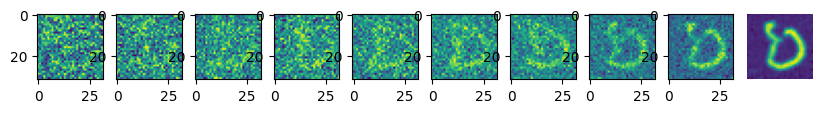

EPOCH 11
 batch0, running_loss0.03226868063211441
 batch100, running_loss0.029928675400886205
 batch200, running_loss0.030064188388746176
 batch300, running_loss0.03014255984627527
 batch400, running_loss0.030145121222719586
 batch500, running_loss0.030150978199527886
 batch600, running_loss0.030311249980637913
 batch700, running_loss0.030370432261733627
 batch800, running_loss0.030335021597076295
 batch900, running_loss0.030257152978508638


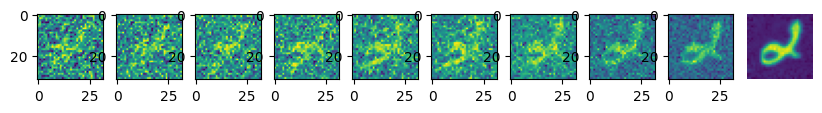

EPOCH 12
 batch0, running_loss0.02899259142577648
 batch100, running_loss0.0298750211327973
 batch200, running_loss0.02948149226012811
 batch300, running_loss0.029602588404997243
 batch400, running_loss0.029636465431077223
 batch500, running_loss0.02962258000097827
 batch600, running_loss0.029718602699120706
 batch700, running_loss0.029879015146325558
 batch800, running_loss0.02991955057158601
 batch900, running_loss0.029881264472775136


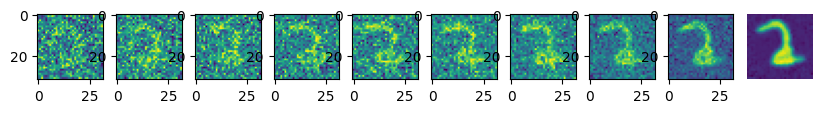

EPOCH 13
 batch0, running_loss0.029023028910160065
 batch100, running_loss0.030348760011320065
 batch200, running_loss0.030132212652940655
 batch300, running_loss0.030214894290679317
 batch400, running_loss0.030153453531222153
 batch500, running_loss0.030032306307268712
 batch600, running_loss0.029937720623567775
 batch700, running_loss0.02983418796291195
 batch800, running_loss0.029855015670203985
 batch900, running_loss0.02989583844928842


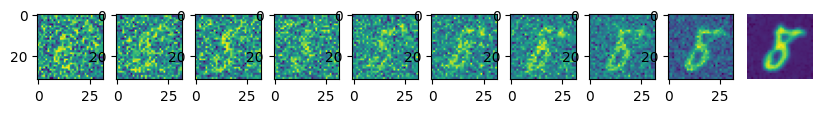

EPOCH 14
 batch0, running_loss0.032164908945560455
 batch100, running_loss0.028616657794112026
 batch200, running_loss0.028961086692056846
 batch300, running_loss0.02915581722938737
 batch400, running_loss0.02930049105846971
 batch500, running_loss0.029456527762397558
 batch600, running_loss0.029358259688895473
 batch700, running_loss0.029394763233551967
 batch800, running_loss0.029353370369131795
 batch900, running_loss0.029358201681922595


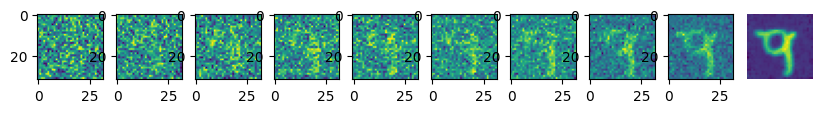

EPOCH 15
 batch0, running_loss0.029508940875530243
 batch100, running_loss0.029518174892752477
 batch200, running_loss0.029429281575243865
 batch300, running_loss0.02939103823464574
 batch400, running_loss0.029375309579799003
 batch500, running_loss0.02944209843784749
 batch600, running_loss0.029488241151223168
 batch700, running_loss0.02941204141161156
 batch800, running_loss0.029350928671555723
 batch900, running_loss0.029347888984770146


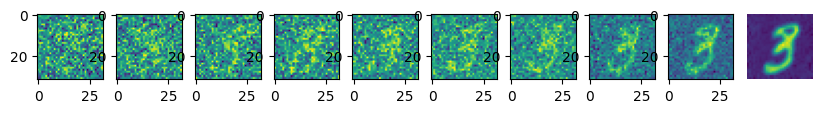

EPOCH 16
 batch0, running_loss0.030566200613975525
 batch100, running_loss0.029557305249837365
 batch200, running_loss0.029234972694397565
 batch300, running_loss0.02933489739820609
 batch400, running_loss0.02942681174604524
 batch500, running_loss0.029418615523926512
 batch600, running_loss0.029442991047924052
 batch700, running_loss0.02946045297263097
 batch800, running_loss0.029362507787685416
 batch900, running_loss0.029286592082429543


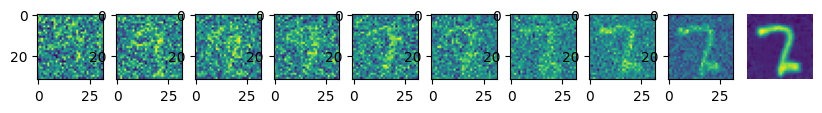

EPOCH 17
 batch0, running_loss0.03988581895828247
 batch100, running_loss0.02964769467932753
 batch200, running_loss0.029603443029730475
 batch300, running_loss0.029354439986455084
 batch400, running_loss0.029489696838723455
 batch500, running_loss0.029377859152719645
 batch600, running_loss0.029207344466011458
 batch700, running_loss0.02913441278635605
 batch800, running_loss0.029037462384643477
 batch900, running_loss0.02909437688139911


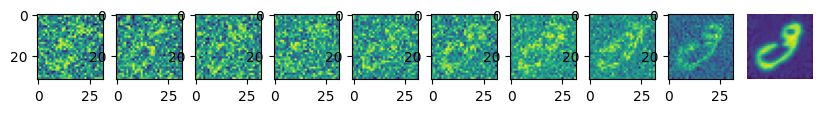

EPOCH 18
 batch0, running_loss0.03082871064543724
 batch100, running_loss0.028767520174531654
 batch200, running_loss0.028597532942965256
 batch300, running_loss0.028825780710954207
 batch400, running_loss0.028757666662669837
 batch500, running_loss0.02885764544298073
 batch600, running_loss0.028773378339067672
 batch700, running_loss0.028623556394060907
 batch800, running_loss0.02863847618264503
 batch900, running_loss0.028720630192250577


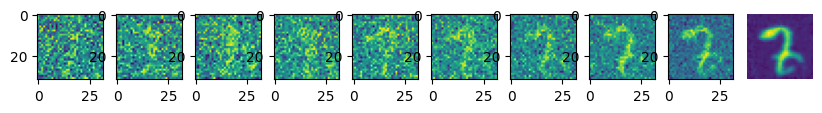

EPOCH 19
 batch0, running_loss0.034833505749702454
 batch100, running_loss0.029071705397402885
 batch200, running_loss0.02870314091036272
 batch300, running_loss0.028789380342510846
 batch400, running_loss0.02868190495543498
 batch500, running_loss0.028613528184696823
 batch600, running_loss0.02865827194230628
 batch700, running_loss0.028592132273716014
 batch800, running_loss0.028683678038911278
 batch900, running_loss0.028671820595298173


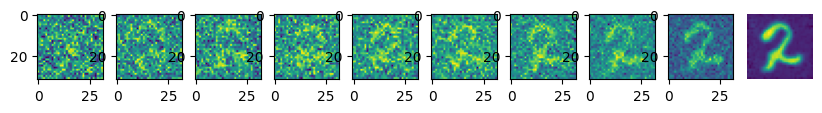

EPOCH 20
 batch0, running_loss0.03194998577237129
 batch100, running_loss0.02892422943495878
 batch200, running_loss0.02854630507677052
 batch300, running_loss0.028341802424964715
 batch400, running_loss0.02843157960533947
 batch500, running_loss0.02843344937303585
 batch600, running_loss0.02855159198794012
 batch700, running_loss0.028570683667709925
 batch800, running_loss0.028568267743202036
 batch900, running_loss0.028506842957650384


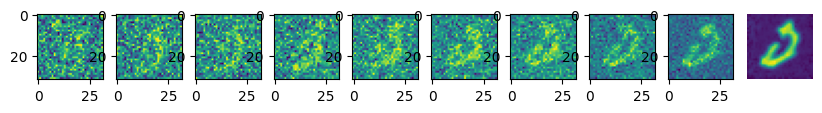

EPOCH 21
 batch0, running_loss0.03466666117310524
 batch100, running_loss0.0281241275370121
 batch200, running_loss0.02802464843204069
 batch300, running_loss0.028349980662431433
 batch400, running_loss0.028477111366807376
 batch500, running_loss0.028501663342148004
 batch600, running_loss0.028440263453939196
 batch700, running_loss0.028653038641738144
 batch800, running_loss0.028596345942174452
 batch900, running_loss0.028533087034485448


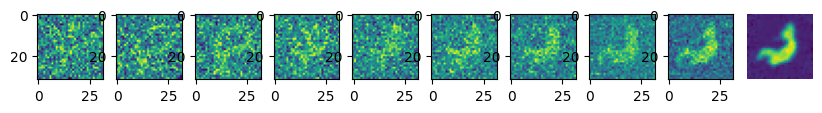

EPOCH 22
 batch0, running_loss0.030727865174412727
 batch100, running_loss0.02784289519238
 batch200, running_loss0.02802608262247114
 batch300, running_loss0.028037387921020042
 batch400, running_loss0.02799969845151812
 batch500, running_loss0.02807163556446572
 batch600, running_loss0.02806543877748106
 batch700, running_loss0.028152994952362547
 batch800, running_loss0.02821150700446595
 batch900, running_loss0.028258643095504563


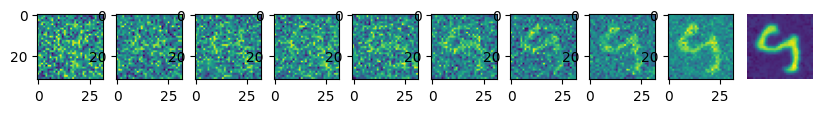

EPOCH 23
 batch0, running_loss0.02318451926112175
 batch100, running_loss0.027909790008965107
 batch200, running_loss0.028132362541422914
 batch300, running_loss0.028176486745872767
 batch400, running_loss0.02818316253287685
 batch500, running_loss0.02819053371791949
 batch600, running_loss0.02813575027228493
 batch700, running_loss0.028263054469257552
 batch800, running_loss0.028272428464949057
 batch900, running_loss0.028328104490428732


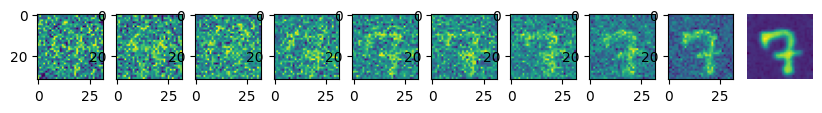

EPOCH 24
 batch0, running_loss0.02502003312110901
 batch100, running_loss0.02751149262974758
 batch200, running_loss0.027892640092183108
 batch300, running_loss0.028085447105260387
 batch400, running_loss0.028080587300873754
 batch500, running_loss0.028157268098728386
 batch600, running_loss0.027997151416991394
 batch700, running_loss0.028085715704718434
 batch800, running_loss0.02819685194264637
 batch900, running_loss0.02812724540032835


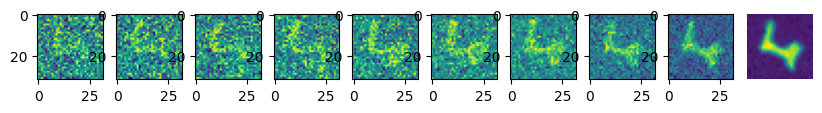

EPOCH 25
 batch0, running_loss0.02898244559764862
 batch100, running_loss0.027900604199212375
 batch200, running_loss0.02813905270872128
 batch300, running_loss0.028277919438986287
 batch400, running_loss0.028349037916211416
 batch500, running_loss0.028231949175516528
 batch600, running_loss0.02825191555647009
 batch700, running_loss0.028178539908306405
 batch800, running_loss0.028221568274084993
 batch900, running_loss0.028185682067364354


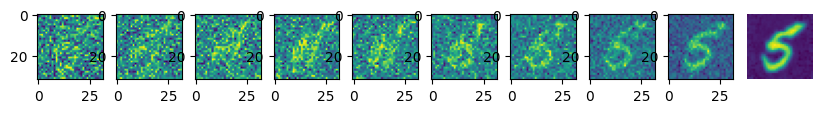

EPOCH 26
 batch0, running_loss0.02363455668091774
 batch100, running_loss0.027764272239833774
 batch200, running_loss0.02750410446294801
 batch300, running_loss0.027810710800991106
 batch400, running_loss0.02776860823376369
 batch500, running_loss0.02772864049110941
 batch600, running_loss0.027669895285377884
 batch700, running_loss0.027801445038316934
 batch800, running_loss0.027848308122299433
 batch900, running_loss0.027885710533199777


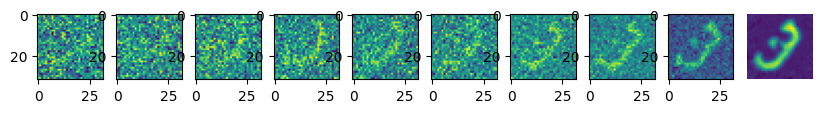

EPOCH 27
 batch0, running_loss0.024718105792999268
 batch100, running_loss0.02796293605155874
 batch200, running_loss0.02788025619860609
 batch300, running_loss0.027821979284336003
 batch400, running_loss0.027848709244606203
 batch500, running_loss0.027768791082525206
 batch600, running_loss0.02770950638699948
 batch700, running_loss0.027864470549150984
 batch800, running_loss0.027877683987313145
 batch900, running_loss0.027934489980521927


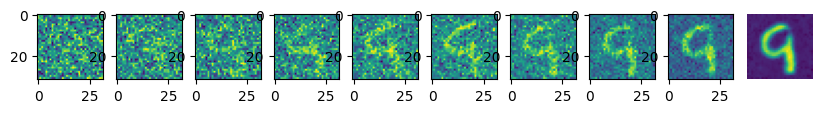

EPOCH 28
 batch0, running_loss0.025369111448526382
 batch100, running_loss0.02669717032130402
 batch200, running_loss0.02708846271334596
 batch300, running_loss0.027290927834090997
 batch400, running_loss0.02753448521630128
 batch500, running_loss0.02749782006540698
 batch600, running_loss0.027566889858806193
 batch700, running_loss0.027559778295701817
 batch800, running_loss0.02760298480599486
 batch900, running_loss0.02759973359574356


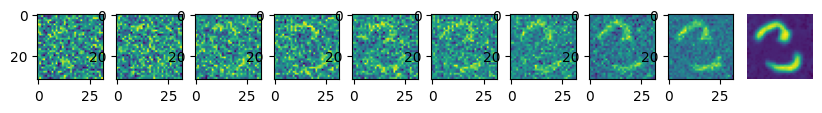

EPOCH 29
 batch0, running_loss0.026409748941659927
 batch100, running_loss0.028028874464406824
 batch200, running_loss0.0280327565171084
 batch300, running_loss0.02793738956368247
 batch400, running_loss0.027889902663981527
 batch500, running_loss0.027837385038683514
 batch600, running_loss0.02776590840094498
 batch700, running_loss0.027770505317310124
 batch800, running_loss0.027797260985578342
 batch900, running_loss0.027817596144949424


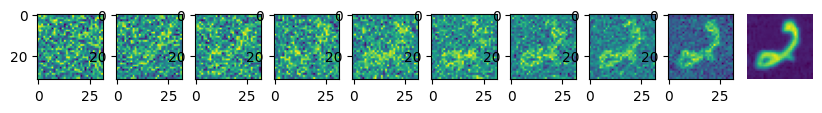

EPOCH 30
 batch0, running_loss0.02478659525513649
 batch100, running_loss0.02748397260092863
 batch200, running_loss0.02821528551108505
 batch300, running_loss0.028251427105098863
 batch400, running_loss0.028115991907115293
 batch500, running_loss0.027909333075948818
 batch600, running_loss0.02777084851708765
 batch700, running_loss0.027734976285768303
 batch800, running_loss0.027746742505222074
 batch900, running_loss0.02773878076108592


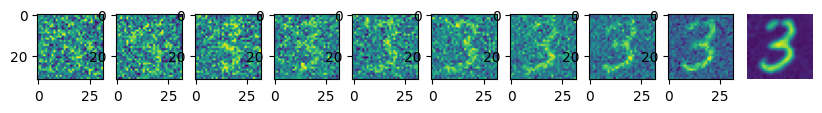

EPOCH 31
 batch0, running_loss0.027786068618297577
 batch100, running_loss0.028009573477182057
 batch200, running_loss0.02771682208820955
 batch300, running_loss0.027648378547243897
 batch400, running_loss0.027758282941401452
 batch500, running_loss0.02759149318148276
 batch600, running_loss0.027539068064381198
 batch700, running_loss0.027621252143412788
 batch800, running_loss0.027642329247870696
 batch900, running_loss0.027608884878861786


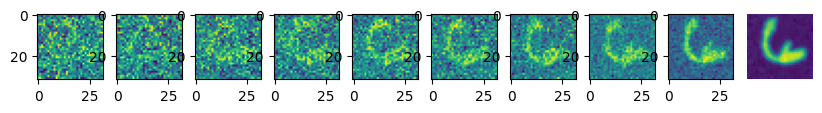

EPOCH 32
 batch0, running_loss0.0294702909886837
 batch100, running_loss0.028239718758233702
 batch200, running_loss0.02777530064815609
 batch300, running_loss0.02779888575803798
 batch400, running_loss0.027795885984514122
 batch500, running_loss0.02780663090090671
 batch600, running_loss0.02769703912035796
 batch700, running_loss0.027703170307225064
 batch800, running_loss0.02769317531425706
 batch900, running_loss0.027697754393307933


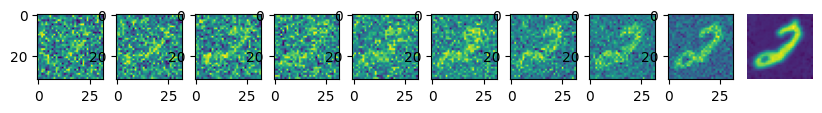

EPOCH 33
 batch0, running_loss0.025499967858195305
 batch100, running_loss0.027182567292953482
 batch200, running_loss0.02726882363470336
 batch300, running_loss0.027293524701779467
 batch400, running_loss0.027416892307914997
 batch500, running_loss0.027323297825372385
 batch600, running_loss0.027403016173328815
 batch700, running_loss0.02735438355153025
 batch800, running_loss0.027421845941712496
 batch900, running_loss0.027434434067792817


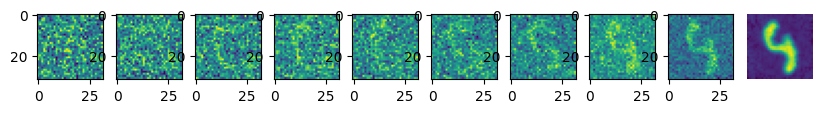

EPOCH 34
 batch0, running_loss0.02876644767820835
 batch100, running_loss0.027598349451281055
 batch200, running_loss0.02736241618792216
 batch300, running_loss0.027362587901939982
 batch400, running_loss0.027340419107393137
 batch500, running_loss0.027409623654005295
 batch600, running_loss0.027485234504829033


KeyboardInterrupt: 

In [ ]:
random_noise = RandomNoise(device=my_device)
EPOCHS = 500

# loss_fn = torch.nn.L1Loss()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(EPOCHS):
    print(f'EPOCH {epoch}')
    model.train()
    running_loss = 0.
    for train_idx, data in enumerate(training_loader):
        img_tensors , labels = data
        img_tensors = img_tensors.to(my_device)
        optimizer.zero_grad()
        sample_times = torch.randint(0, SAMPLE_STEP, (BATCH_SIZE,))
        noise_imgs, random_noises = random_noise.apply_random_noise(img_tensors,sample_times)

        noise_imgs = noise_imgs.to(my_device)
        random_noises = random_noises.to(my_device)
        sample_times = sample_times.to(my_device)

        noise_pred = model(noise_imgs, sample_times[:,None].float())
        loss = loss_fn(random_noises,noise_pred)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        if train_idx % 100 == 0:
            print(f' batch{train_idx}, running_loss{running_loss/(train_idx+1)}')

    model.eval()
    fig, axes = plt.subplots(1, 10, figsize=(10, 1))
    noise_img = torch.normal(0.0, 1.0, (1,1,32,32), device=my_device)
    plt_idx = 0
    for sample_step_int in reversed(range(0, SAMPLE_STEP)):
        sample_step = torch.tensor(sample_step_int, dtype=torch.float32, device=my_device)
        sample_step = sample_step[None,None]
        pred_noise = model(noise_img, sample_step)
        noise_img = random_noise.restore_img(noise_img, pred_noise, sample_step_int)
        noise_img = torch.clamp(noise_img, -1.0, 1.0)

        if sample_step % (SAMPLE_STEP/10) == 1:
            noise_img_clamp = torch.clamp(noise_img, -1.0, 1.0)
            noise_img_np = noise_img_clamp.detach().squeeze().to('cpu').numpy()
            axes[plt_idx].imshow((noise_img_np+1)/2)
            plt_idx = plt_idx+1
    plt.axis('off')  # To hide axis
    plt.show()
    # break

